In [33]:
from pathlib import Path

import matplotlib.pyplot as plt
from scipy.linalg import eig, solve

import h5py
import numpy as np
from magtense.utils import plot_M_thin_film

from koopmag.database import create_db_mp
from koopmag.utils import plot_dynamics

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

In [3]:
datapath = Path().cwd().parent / "data"
db = h5py.File(datapath / "4_500_36_9.h5", "r")

print("Attributes of database:")
for key in db.attrs:
    print(f"{key}: {db.attrs[key]}")

print("\nData in the database:")
for key in db:
    print(f"{key}: {db[key].shape}")

Attributes of database:
grid_size: [5.00e-07 1.25e-07 3.00e-09]
h_ext_angle: [  0 360]
h_ext_norm: [ 0 50]
res: [36  9  1]
seed: 0
t_per_step: 4e-12
t_steps: 500

Data in the database:
field: (4, 3)
sequence: (4, 500, 36, 9, 3)


# ROM for timestepping for a given $\mathbf{H}_{ext}$

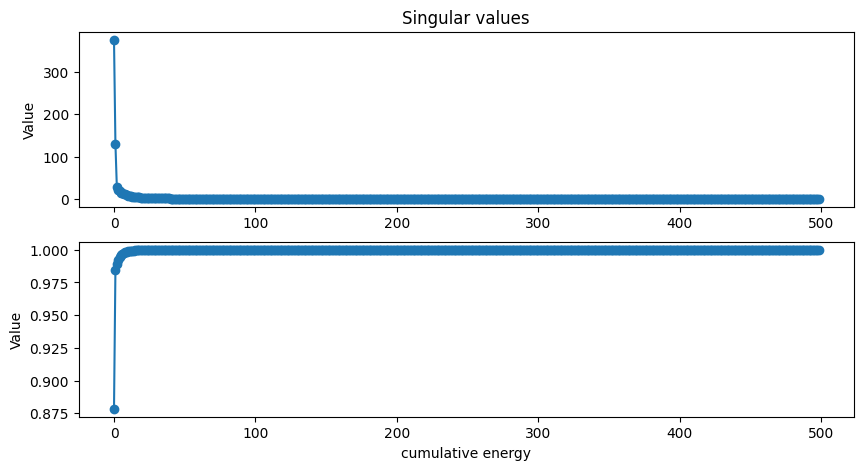

In [4]:
X = db["sequence"][0]   # original shape (t_steps, x_dim, y_dim, 3)
data_dim = X.shape[1:]  # (x_dim, y_dim, magnetization components (3))

X = np.permute_dims(X, (1, 2, 3, 0))    # reshape to (x_dim, y_dim, 3, t_steps)

X_flat = X.reshape(-1, X.shape[-1])  # flatten data to (x_dim * y_dim * 3, t_steps)

X1 = X_flat[:, :-1] # create matrix from t=[t_{0},t_{n-1}]
X2 = X_flat[:, 1:]  # create matrix from t=[t_{1},t_{n}]

#SVD of X1
U, S, VT = np.linalg.svd(X1, full_matrices=False)

fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(S, "o-")
axs[0].set(title="Singular values", ylabel="Value")

energy = np.cumsum(S ** 2 / np.sum(S ** 2))
axs[1].plot(energy, "o-")
axs[1].set(xlabel="cumulative energy", ylabel="Value")
plt.show()

In [5]:
#trunction
r = np.argmax(energy > 0.99)  # find the index where cumulative energy exceeds 0.99
print(f"number of modes: {r}")
U_r, S_r, VT_r = U[:, :r], S[:r], VT[:r, :]

number of modes: 3


In [6]:
A_tilde = U_r.T @ X2 @ VT_r.T * (1/S_r)
Lambdas, W = eig(A_tilde)

Phi = (X2 @ VT_r.T * (1 / S_r)) @ W

#forecast x_k = Phi @ Lambdas^(k-1) @ b, wher b = Phi @ x_1
x1_tilde = S_r * VT_r[:,0]
b = solve(W * Lambdas, x1_tilde)

def forecast(k0, kf, Phi, Lambdas, b) -> np.ndarray:
    x_forecast = np.zeros((kf - k0 + 1, Phi.shape[0]))

    for i in range(kf - k0 + 1):
        x_forecast[i,:] = np.real((Phi * Lambdas ** (i + k0 - 1)) @ b)

    return x_forecast.T

X_pred = forecast(1, 499, Phi, Lambdas, b)

In [ ]:
def print_error(X, X_pred) -> np.array:
    norm = np.linalg.norm(X - X_pred, axis=0)
    norm = norm / np.linalg.norm(X, axis=0)  # normalize by the original data
    print("Relative errors:")
    print(f"  mean error: {np.mean(norm):.2f}, min error: {np.min(norm):.2f}, "
          f"max error: {np.max(norm):.2f}")
    return norm

In [8]:
errors = print_error(X2, X_pred)

Relative errors:
  mean error: 0.87, min error: 0.27, max error: 1.32


In [9]:
print(errors.shape)

(499,)


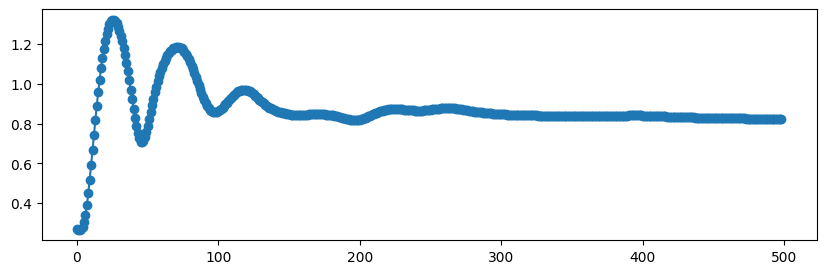

In [10]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(errors, "o-")
plt.show()

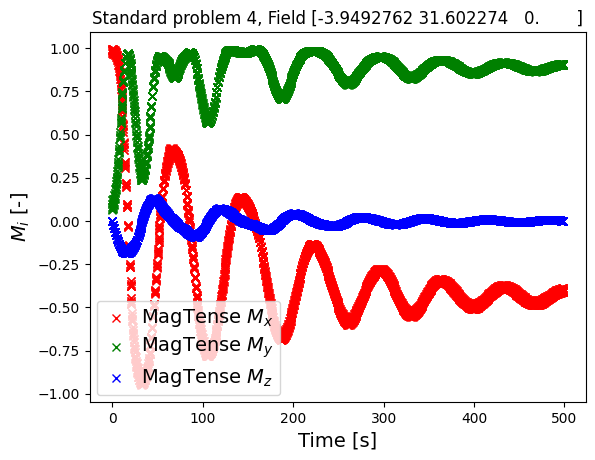

In [11]:
field_idx = 0

plot_dynamics(
    np.arange(db["sequence"][field_idx].shape[0]),
    db["sequence"][field_idx],
    field=db["field"][field_idx],
)

In [12]:
db["sequence"][field_idx].shape

(500, 36, 9, 3)

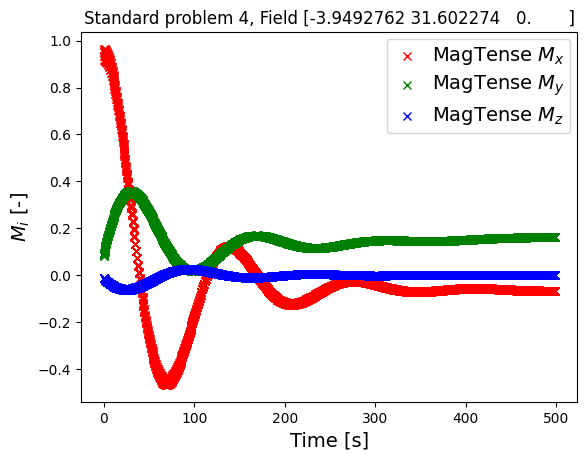

In [14]:
X_reshape = X_pred.reshape((*data_dim, X_pred.shape[-1]))
X_reshape = np.permute_dims(X_reshape, (3, 0, 1, 2))

plot_dynamics(
    np.arange(db["sequence"][field_idx].shape[0] - 1),
    X_reshape,
    field=db["field"][field_idx],
)

### Remarks on DMD for micromagnetism

We note that the dynamics are too nonlinear for DMD to handle. Even given all of the data, we cannot construct a linear operator in reduced space that is able to timestep from $t_0$ to $t_n$ recursively without large degradation to the predictions. This indicates the need for some nonlinear method.

In [15]:
class Encoder(nn.Module):
    def __init__(self, dim_list, act_fn=nn.Tanh) -> None:
        super(Encoder, self).__init__()

        module_list = []
        for i in range(len(dim_list)-1):
            module_list.append(nn.Linear(dim_list[i], dim_list[i+1]))
            if i != len(dim_list)-2:
                module_list.append(act_fn())

        self.fc = nn.Sequential(*module_list)

    def forward(self, x) -> torch.Tensor:
        return self.fc(x)
    
class Decoder(nn.Module):
    def __init__(self, dim_list, act_fn=nn.Tanh) -> None:
        super(Decoder, self).__init__()
        module_list = []
        for i in range(len(dim_list)-1, 0, -1):
            module_list.append(nn.Linear(dim_list[i], dim_list[i-1]))
            if i != 1:
                module_list.append(act_fn())

        self.fc = nn.Sequential(*module_list)

    def forward(self, x) -> torch.Tensor:
        return self.fc(x)



class DeepKoopman(nn.Module):

    def __init__(self, dim_list, act_fn=nn.Tanh) -> None:
        super(DeepKoopman, self).__init__()
        self.encoder = Encoder(dim_list, act_fn)
        self.decoder = Decoder(dim_list, act_fn)

        self.B = nn.Parameter(torch.empty(3, dim_list[-1])) # shape (n_magnetization, d)
        nn.init.xavier_uniform_(self.B, gain=0.01)

    def compute_linear_operator(self, Xtilde, Ytilde) -> torch.Tensor:
        #with torch.no_grad():
        self.A = torch.linalg.pinv(Xtilde) @ Ytilde
        return self.A

    def forward(self, X, Y, U=None) -> tuple[torch.Tensor, torch.Tensor]:
        '''
        params:
        X: input data (n x m)
        Y: target data (n x m)
        U: external effect (n x 3)
        '''
        T = X.shape[0]
        T_half = T // 2
        Xtilde = self.encoder(X)    # encode X: (n x m)  -> Xtilde: (n x d)
        Ytilde = self.encoder(Y)    # encode Y: (n x m)  -> Ytilde: (n x d)

        ext_effect = U[:T_half, :] @ self.B if U is not None else 0 # shape (n//2 x d)

        # compute linear operator according to 
        # A = (Ytilde - B @ U) @ Xtilde^+
        A = self.compute_linear_operator(
            Xtilde[:T_half,:], Ytilde[:T_half,:] - ext_effect
            )

        Ytilde_pred_list = [Xtilde[0] @ A]
        for t in range(1, T):
            next_pred = Ytilde_pred_list[t-1] @ A
            if U is not None:
                next_pred += U[t,:] @ self.B
            Ytilde_pred_list.append(next_pred)
        
        Ytilde_pred = torch.stack(Ytilde_pred_list, dim=0)
        
        Xhat = self.decoder(Xtilde)
        Yhat = self.decoder(Ytilde_pred)

        return Xhat, Yhat
    
    
    def predict(self, X, T, U=None) -> torch.Tensor:
        if len(X.shape) == 1:
            X = X.unsqueeze(0)  # make it (1, input_dim)

        with torch.no_grad():
            Xtilde0 = self.encoder(X)    # encode X: (n x m)  -> Xtilde: (n x d)
            Ytilde_pred = torch.zeros((T, Xtilde0.shape[1])).to(Xtilde0.device)
            Ytilde_pred[0] = Xtilde0 @ self.A 
            if U is not None:
                Ytilde_pred[0] += U[0,:] @ self.B
            for t in range(1, T):
                Ytilde_pred[t] = Ytilde_pred[t-1] @ self.A
                if U is not None:
                    Ytilde_pred[t] += U[t,:] @ self.B
            
            Yhat = self.decoder(Ytilde_pred)
        return Yhat

In [19]:
m = int(np.prod(data_dim))  # input dimension
dim_list = [m, 64, 10]
act_fn = nn.Tanh

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Xtrain = torch.tensor(X1.T, dtype=torch.float32).to(device)
Ytrain = torch.tensor(X2.T, dtype=torch.float32).to(device)

U = torch.stack([torch.tensor(db["field"][0], dtype=torch.float32) 
                 for i in range(Xtrain.shape[0])]).to(device)

koopman = DeepKoopman(dim_list=dim_list, act_fn=act_fn).to(device)

In [46]:
U.shape

torch.Size([499, 3])

In [30]:
optimizer = optim.Adam(koopman.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 1000
print_every = 100

losses = np.zeros(epochs)
for epoch in range(epochs):
    koopman.train()
    optimizer.zero_grad()

    Xhat, Yhat = koopman(Xtrain, Ytrain, U=U)

    loss = criterion(Xhat, Xtrain) + criterion(Yhat, Ytrain)

    losses[epoch] = loss.item()

    loss.backward()
    optimizer.step()

    if epoch % print_every == print_every - 1:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 100, Loss: 0.0032631864305585623
Epoch 200, Loss: 0.0025881591718643904
Epoch 300, Loss: 0.002361128805205226
Epoch 400, Loss: 0.0021848524920642376
Epoch 500, Loss: 0.0020426935516297817
Epoch 600, Loss: 0.0019852775149047375
Epoch 700, Loss: 0.0018298428039997816
Epoch 800, Loss: 0.001740187406539917
Epoch 900, Loss: 0.0016657811356708407
Epoch 1000, Loss: 0.0015977142611518502


In [31]:
koopman.eval()
Yhat = koopman.predict(Xtrain[0,:], 499, U=U).cpu().detach().numpy()

error = np.linalg.norm(Yhat - X2.T, axis=1) / np.linalg.norm(X2.T, axis=1)
error.shape

(499,)

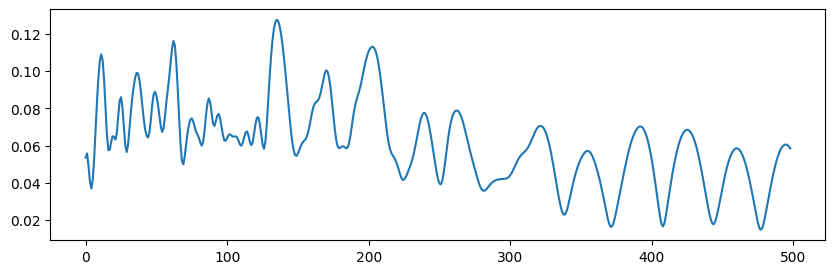

In [32]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(error)
#ax.scatter(np.arange(len(error)), error, s=5, c="r")
plt.show()

In [24]:
Y_reshape = Yhat.reshape((Yhat.shape[0], *data_dim))
Y_reshape.shape

(499, 36, 9, 3)

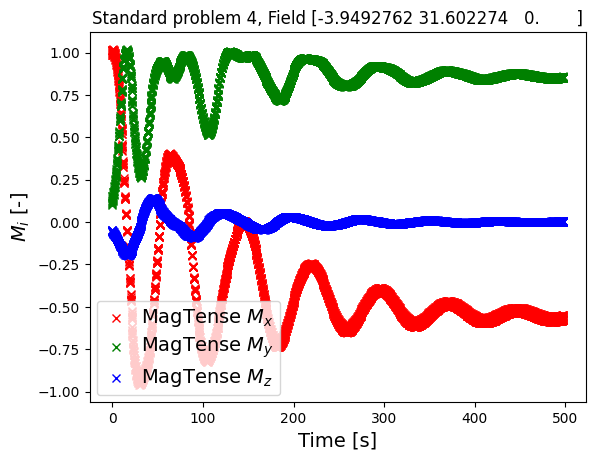

In [25]:
plot_dynamics(
    np.arange(Y_reshape.shape[0]),
    Y_reshape,
    field=db["field"][field_idx],
)

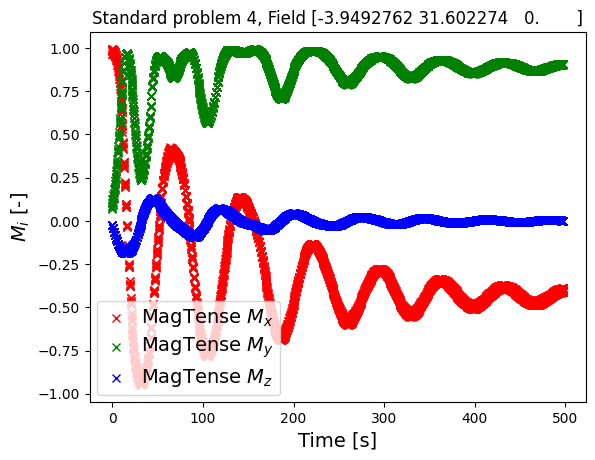

In [150]:
field_idx = 0

plot_dynamics(
    np.arange(db["sequence"][field_idx].shape[0]-1),
    db["sequence"][field_idx][1:],
    field=db["field"][field_idx],
)

In [37]:
koopman.B.shape

torch.Size([3, 10])

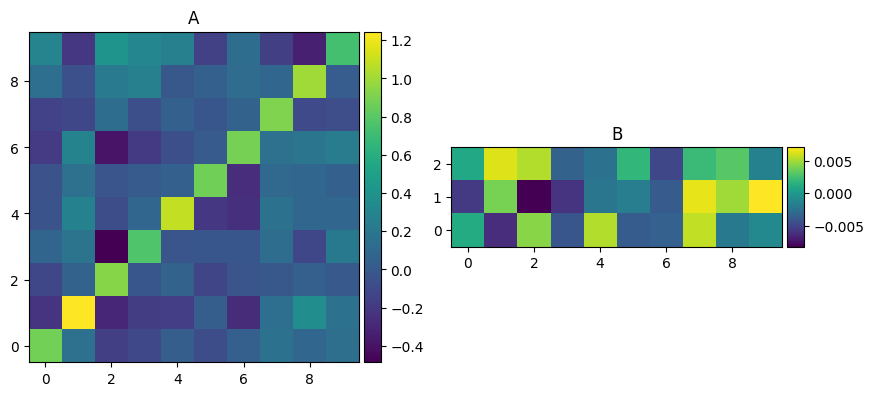

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im1 = axs[0].pcolormesh(
    np.arange(10), 
    np.arange(10), 
    koopman.A.detach().cpu().numpy(),
    shading="auto")

im2 = axs[1].pcolormesh(
    np.arange(10), 
    np.arange(3), 
    koopman.B.detach().cpu().numpy(),
    shading="auto",
    )
axs[0].set(title="A", aspect="equal")
axs[1].set(title="B", aspect="equal")
add_colorbar(im1, fig, axs[0])
add_colorbar(im2, fig, axs[1])
plt.show()